reference:

Time series anomaly detection with LSTM autoencoders using Keras in python:
https://www.curiousily.com/posts/anomaly-detection-in-time-series-with-lstms-using-keras-in-python/

In [1]:
import numpy as np
import pandas as pd
import altair as alt

In [2]:
df = pd.read_csv('./data/GSPC.csv', parse_dates=['Date'], index_col='Date')
df = df[['Close']]
df.head()

,Close
Date,
1988-03-15,266.130005
1988-03-16,268.649994
1988-03-17,271.220001
1988-03-18,271.119995
1988-03-21,268.739990


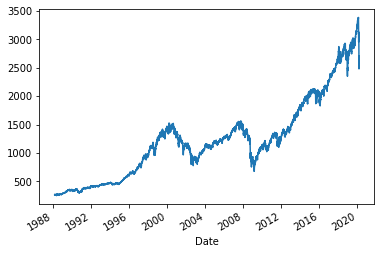

In [3]:
df['Close'].plot()

## Preprocessing

In [4]:
# ds = df['Close']
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:]
train.shape, test.shape

((7660, 1), (404, 1))

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])
train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

/home/danhojin/miniconda2/envs/ray2/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/danhojin/miniconda2/envs/ray2/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [7]:
TIME_STEPS = 30

# samples x time_steps x features

X_train, y_train = create_dataset(
    train[['Close']],
    train.Close,
    TIME_STEPS
)

X_test, y_test = create_dataset(
    test[['Close']],
    test.Close,
    TIME_STEPS
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7630, 30, 1), (7630,), (374, 30, 1), (374,))

## LSTM Autoencoder in Keras

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K

In [9]:
K.clear_session()

model = models.Sequential([
    layers.LSTM(
        64,
        input_shape=(X_train.shape[1], X_train.shape[2])
    ),
    layers.Dropout(0.2),
    layers.RepeatVector(n=X_train.shape[1]),
    layers.LSTM(
        64,
        return_sequences=True
    ),
    layers.TimeDistributed(
        layers.Dense(X_train.shape[2])
    )
])

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [10]:
epochs = 4

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
)
history.history.keys()

Train on 6867 samples, validate on 763 samples
Epoch 1/4
6867/6867 [==============================] - 3s 424us/sample - loss: 0.1521 - val_loss: 0.3098
Epoch 2/4
6867/6867 [==============================] - 1s 134us/sample - loss: 0.0701 - val_loss: 0.1790
Epoch 3/4
6867/6867 [==============================] - 1s 129us/sample - loss: 0.0857 - val_loss: 0.1438
Epoch 4/4
6867/6867 [==============================] - 1s 130us/sample - loss: 0.0842 - val_loss: 0.2236


dict_keys(['loss', 'val_loss'])

In [11]:
hdf = pd.DataFrame({
    'dataset': ['train'] * epochs + ['val'] * epochs,
    'loss': history.history['loss'] + history.history['val_loss'],
    'epoch': list(range(1, epochs + 1)) + list(range(1, epochs + 1))
})
alt.Chart(hdf).mark_line().encode(
    x='epoch',
    y='loss',
    color='dataset'
)

alt.Chart(...)

## Finding Anomalies

In [12]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

In [13]:
alt.data_transformers.disable_max_rows()

df = pd.DataFrame({'loss': train_mae_loss.reshape((-1,))})
alt.Chart(df).mark_bar().encode(
    alt.X('loss:Q', bin=alt.Bin(maxbins=50)),
    y='count()'
)

alt.Chart(...)

In [52]:
THRESHOLD = 0.8
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['Close'] = test[TIME_STEPS:].Close
anomalies = test_score_df[test_score_df.anomaly == True]

In [53]:
test_score_df = test_score_df.reset_index()
test_score_df = test_score_df.drop(['Close'], axis=1)
test_score_df = test_score_df[test_score_df['anomaly'] == True]
test_score_df

,Date,loss,threshold,anomaly
302,2019-11-29,0.803301,0.8,True
303,2019-12-02,0.809045,0.8,True
304,2019-12-03,0.818411,0.8,True
305,2019-12-04,0.828285,0.8,True
306,2019-12-05,0.836235,0.8,True
...,...,...,...,...
369,2020-03-09,1.129725,0.8,True
370,2020-03-10,1.148671,0.8,True
371,2020-03-11,1.147693,0.8,True
372,2020-03-12,1.154517,0.8,True


In [54]:
df = pd.read_csv('./data/GSPC.csv', parse_dates=['Date'])
# alt.Chart(df).mark_line().encode(
#     x='Date',
#     y='Close'
# )

In [55]:
test_score_df = pd.merge(test_score_df, df, left_on='Date', right_on='Date', how='left')
# test_score_df

In [56]:
df['anomaly'] = False
# test_score_df['anomaly'] = True
df2 = pd.concat([
    df[['Date', 'Close', 'anomaly']],
    test_score_df[['Date', 'Close', 'anomaly']]
], ignore_index=True)
df2

,Date,Close,anomaly
0,1988-03-15,266.130005,False
1,1988-03-16,268.649994,False
2,1988-03-17,271.220001,False
3,1988-03-18,271.119995,False
4,1988-03-21,268.739990,False
...,...,...,...
8131,2020-03-09,2746.560059,True
8132,2020-03-10,2882.229980,True
8133,2020-03-11,2741.379883,True
8134,2020-03-12,2480.639893,True


In [57]:
c1 = alt.Chart(df2[df2['anomaly'] == False]).mark_line().encode(
    x='Date',
    y='Close'
)
c2 = alt.Chart(df2[df2['anomaly'] == True]).mark_circle(
    color='red'
).encode(
    x='Date',
    y='Close'
)
alt.layer(c1, c2).interactive()

alt.LayerChart(...)